In [43]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras import backend as K



In [44]:
data= pd.read_csv("C:\\Users\\DELL\\Desktop\\weather forecasting\\jena_climate_2009_2016.csv")

In [45]:
# Preprocess the data
data['Date Time'] = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')
data.set_index('Date Time', inplace=True)
features = ['T (degC)', 'p (mbar)', 'rh (%)', 'wv (m/s)']
data = data[features]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

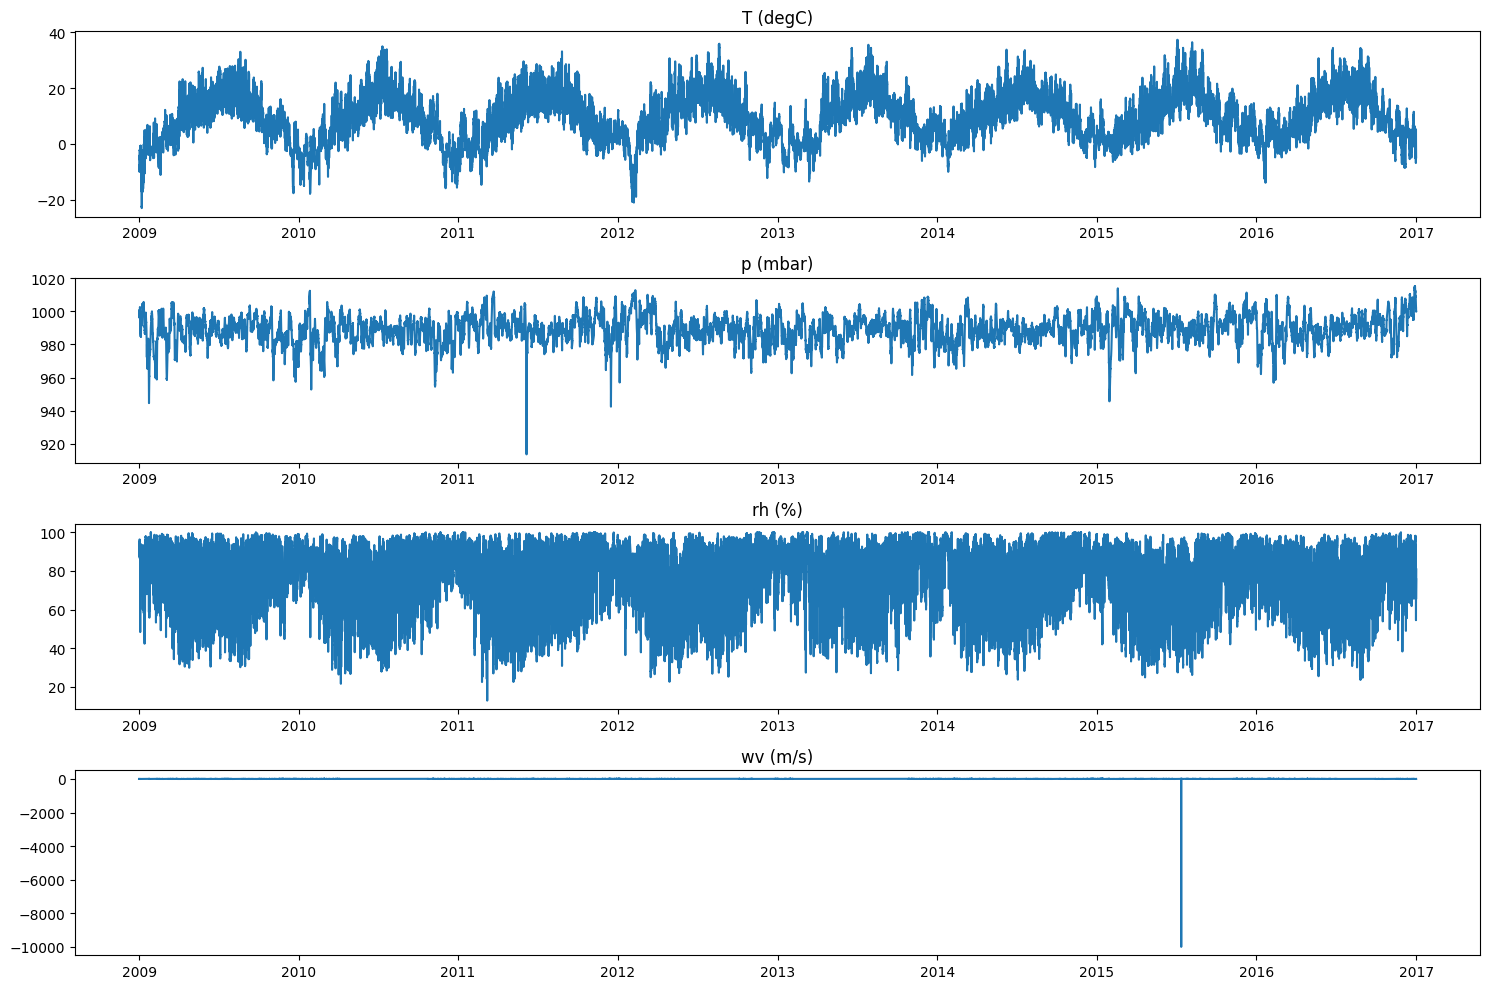

In [46]:
# Visualize the raw data
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    plt.plot(data.index, data[feature], label=feature)
    plt.title(feature)
plt.tight_layout()
plt.show()

In [47]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length][0])  # Predicting the temperature
    return np.array(sequences), np.array(targets)

seq_length = 50
X, y = create_sequences(data_scaled, seq_length)
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [48]:
# Define a HyperModel for Keras Tuner
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(seq_length, len(features))))
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16), return_sequences=True))
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16)))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mean_squared_error')
        return model

In [50]:
# Initialize the RandomSearch tuner
tuner = RandomSearch(MyHyperModel(),
                     objective='val_loss',
                     max_trials=10,
                     executions_per_trial=2,
                     directory='hyperparameter_tuning',
                     project_name='lstm_temperature_prediction')
K.clear_session()


In [51]:

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

   


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
112               |112               |units
0.001             |0.001             |learning_rate

Epoch 1/10
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 908s 86ms/step - loss: 9.4748e-04 - val_loss: 1.5167e-05
Epoch 2/10
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 841s 78ms/step - loss: 2.0646e-05 - val_loss: 1.5560e-05
Epoch 3/10
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 831s 79ms/step - loss: 1.6899e-05 - val_loss: 3.5062e-05
Epoch 4/10
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 847s 81ms/step - loss: 1.5760e-05 - val_loss: 2.3402e-05
Epoch 5/10
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 891s 85ms/step - loss: 1.5272e-05 - val_loss: 2.2854e-05
Epoch 6/10
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 930s 88ms/step - loss: 1.4429e-05 - val_loss: 1.4095e-05
Epoch 7/10
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 893s 85ms/step - loss: 1.4560e-05 - val_loss: 2.4307e-05
Epoch 8/10
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 1037s 99ms/step - loss: 1.4185e-05 - val_loss: 2.6928e-05
Epoch 9/10
105

KeyboardInterrupt: 

In [30]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [31]:
# Train the best model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 359s 34ms/step - loss: 1.8272e-05 - val_loss: 1.5048e-05
Epoch 2/50
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 357s 34ms/step - loss: 1.5029e-05 - val_loss: 1.4572e-05
Epoch 3/50
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 357s 34ms/step - loss: 1.4818e-05 - val_loss: 1.8622e-05
Epoch 4/50
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 386s 34ms/step - loss: 1.4523e-05 - val_loss: 2.0236e-05
Epoch 5/50
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 346s 33ms/step - loss: 1.4228e-05 - val_loss: 1.9025e-05
Epoch 6/50
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 346s 33ms/step - loss: 1.3822e-05 - val_loss: 1.9550e-05
Epoch 7/50
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 346s 33ms/step - loss: 1.3736e-05 - val_loss: 1.6411e-05
Epoch 8/50
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 367s 35ms/step - loss: 1.3640e-05 - val_loss: 1.6284e-05
Epoch 9/50
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 367s 35ms/step - loss: 1.3436e-05 - val_loss: 1.6751e-05
Epoch 10/50
10513/10513 ━━━━━━━━━━━━━━━━━━━━ 374s 36ms/step - loss: 1.3162e-05 - val_loss: 

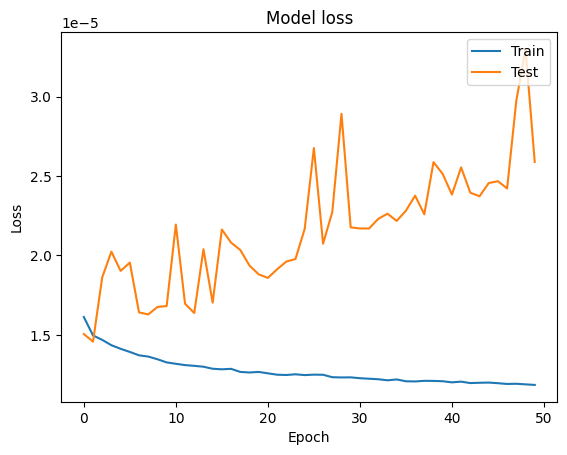

In [32]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [33]:
# Make predictions
y_pred = best_model.predict(X_test)


2629/2629 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step


In [34]:
# Invert scaling for predictions
y_test_scaled = y_test.reshape(-1, 1)
y_pred_scaled = y_pred.reshape(-1, 1)

y_test_inv = scaler.inverse_transform(np.concatenate((y_test_scaled, X_test[:, -1, 1:]), axis=1))[:, 0]
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred_scaled, X_test[:, -1, 1:]), axis=1))[:, 0]


In [37]:
# Filter out zero values for MAPE calculation
non_zero_indices = y_test_inv != 0
y_test_inv_filtered = y_test_inv[non_zero_indices]
y_pred_inv_filtered = y_pred_inv[non_zero_indices]


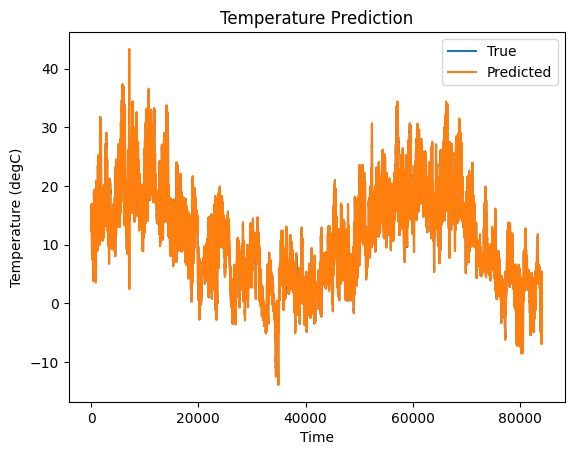

In [38]:
# Plot predictions vs actual values
plt.plot(y_test_inv, label='True')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature (degC)')
plt.legend()
plt.show()


In [39]:
# Calculate MAPE and accuracy
mape = np.mean(np.abs((y_test_inv_filtered - y_pred_inv_filtered) / y_test_inv_filtered)) * 100
accuracy = 100 - mape

print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 96.00%
